# Обученная машина(решение задачи с использованием KNN)

Рассмотрим робота на дискретной двумерной плоскости, который за каждый момент дискретного времени может передвинуться на одну позицию вправо, влево, вверх или вниз. На плоскости разбросаны метки одного из четырёх классов, анализируя которые робот может (но не обязан) корректировать своё перемещение. Пусть метки класса 0 соответствуют сигналу переместиться вправо, 1 – влево, 2 – вверх, 3 – вниз.

Передвижение робота осуществляется по следующему правилу: с вероятностью 0.2 робот передвинется вправо, и с вероятностью 0.8 – оценит, метки какого класса преобладают среди k его ближайших соседей, и передвинется в направлении этого доминирующего класса.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

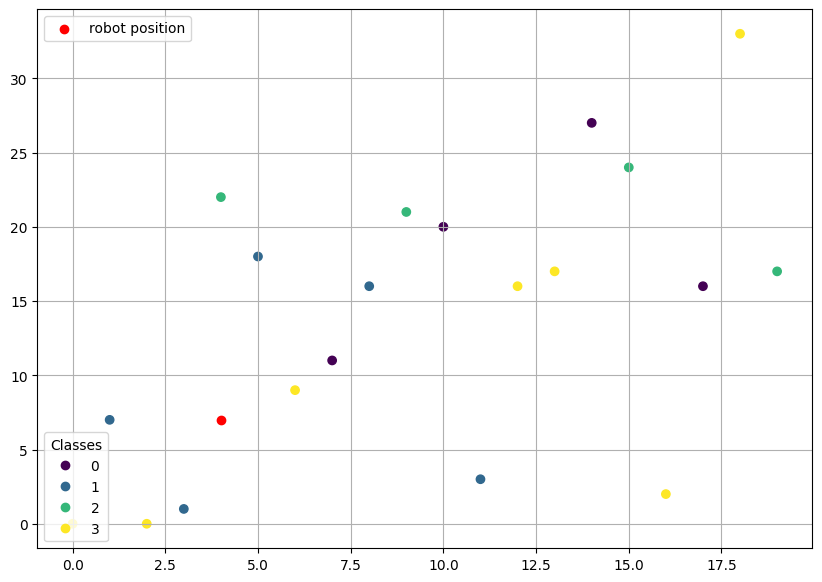

In [13]:
np.random.seed(12345)
x = np.arange(20)
landmarks = x + np.round(np.random.normal(2, 8, 20)) # сгенерируем случайные метки
random_classes = np.random.randint(0, 4, 20)

fig, ax = plt.subplots(figsize = (10, 7))
scatter = ax.scatter(x, landmarks, c = random_classes)
ax.scatter(4, 7, c = 'r', marker = 'o', label = 'robot position')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc = "lower left", title = "Classes")
ax.add_artist(legend1)

plt.plot()
_ = plt.legend()
_ = plt.grid()

Реализуем класс, который задаёт  поведение робота:

Определим атрибуты trajectory (переменная для хранения истории перемещения робота в виде последовательности точек с двумя координатами) и knn (обученный классификатор, который по позиции метки предсказывает её класс).
Определим метод move(),который будет расчитывать новое положение робота и добавлять его в историю перемещений.

In [22]:
class MobileRobot():
    
    def __init__(self, k, initial_position, landmarks, classes):
        '''
        Attributes:
        ------
        k: int
            Number of neighbours
            
        initial_position: ndarray
            Initial position of the robot as a point, e.g. (-1, 1)
            
        landmarks: ndarray
            numpy array of shape (n_landmarks, 2) with the euclidean positions of points
        
        classes: ndarray
            numpy array of shape (n_landmarks, ) with class of landmark for each point in landmarks
        # Хранение истории перемещений
        '''
        self.trajectory = [initial_position.copy()]
        
        # Классификатор kNN для определения классов ориентиров
        self.knn = KNeighborsClassifier(k)
        self.knn.fit(landmarks, classes)
        
        # Соответствие между классами точек и направлениями движения
        # 0 соответствует сигналу переместиться вправо, 1 – влево, 2 – вверх, 3 – вниз
        self.mapping = {0: np.array([1, 0]), 
                        1: np.array([-1, 0]),
                        2: np.array([0, 1]),
                        3: np.array([0, -1])}
        
    def move(self):
        '''
        Рассчитывает новое положение робота и добавляет его в историю
        '''
        cur_pos = self.trajectory[-1]  # Текущая позиция робота
        
        # Подбрасывание монетки с вероятностью 0.2 для перемещения вправо
        if np.random.binomial(1, 0.2):
            new_pos = cur_pos + np.array([1, 0])  # Перемещение вправо
        else:
            # Предсказание класса на основе текущей позиции
            predict_class = self.knn.predict(cur_pos.reshape(1, -1))[0]
            new_pos = cur_pos + self.mapping[predict_class]  # Перемещение согласно предсказанному классу
        
        self.trajectory.append(new_pos)  # Добавление новой позиции в историю перемещений

Далее напишем функцию **conduct_experiments**,которая будет давать на вывод график/графики движения данного робота.Построим к примеру 4 графика и рассмотрим как влияет количество соседей на траекторию движения робота.

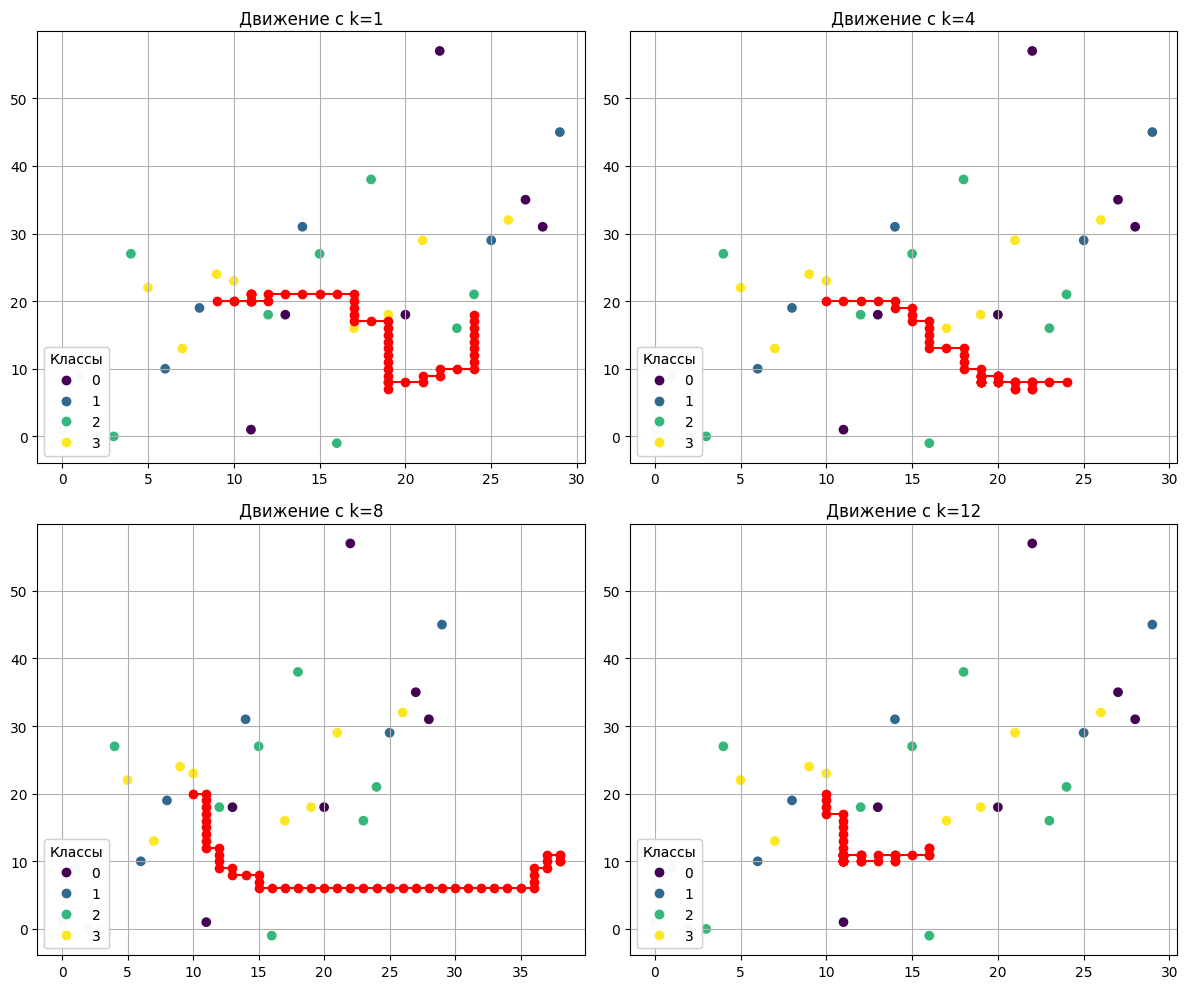

In [37]:
def conduct_experiments(x,k,sizeoffig,
                       mean=0,
                       std=2,
                       n_movements=10,
                       initial_position=np.array([10, 20])):
    
    np.random.seed(12345)
    # Генерация случайных ориентиров
    landmarks = np.vstack((x, x + np.round(np.random.normal(mean, std, len(x))))).T
    
    # Генерация случайных классов ориентиров
    classes = np.random.randint(0, 4, size=len(x))
    
    # Создание подграфиков для каждого значения k
    fig, ax = plt.subplots(sizeoffig[0],sizeoffig[1], figsize=(12, 10))
    ax = ax.flatten()  # Преобразование в одномерный массив для удобного индексирования

    for i, k_value in enumerate(k):
        robot = MobileRobot(k_value, initial_position, landmarks, classes)

        for _ in range(n_movements):
            robot.move()
        
        # Построение графиков
        scatter = ax[i].scatter(landmarks[:, 0], landmarks[:, 1], c=classes)
        legend1 = ax[i].legend(*scatter.legend_elements(),
                                loc="lower left", title="Классы")
        ax[i].add_artist(legend1)

        traj = np.array(robot.trajectory)
        ax[i].plot(traj[:, 0], traj[:, 1],
                   c='r', marker='o', label='Позиция робота')
        
        ax[i].set_title(f'Движение с k={k_value}')
        ax[i].grid()
        
    plt.tight_layout()
    plt.show()
x = np.arange(30)
conduct_experiments(x,mean=3, std=10, n_movements=50,k=[1,4,8,12],sizeoffig=[2,2])

# Итог
Можно заметить,что с низким k движение робота может быть более непредсказуемым и случайным, с высоким k движение становится более плавным и последовательным, что может быть предпочтительным в ситуациях, где требуется точное следование маршруту. Слишком малое значение 𝑘 может привести к переобучению на шуме, в то время как слишком большое значение может привести к недообучению.